# Fast Personalized PageRank Python Implementation

I needed a fast PageRank for [Wikisim](https://github.com/asajadi/wikisim) project. It had to be fast enough to run real time on relatively large graphs. NetworkX was the obvious library to use, however, it needed back and forth translation from my graph representation (which was the pretty standard csr matrix), to its internal graph data structure. These translations were slowing down the process. 

I implemented two versions of the algorithm in Python, both inspired by the sparse fast solutions given in [**Cleve Moler**](https://en.wikipedia.org/wiki/Cleve_Moler)'s book, [*Experiments with MATLAB*](https://www.mathworks.com/content/dam/mathworks/mathworks-dot-com/moler/exm/chapters/pagerank.pdf). The power method is much faster with enough precision for our task. 

### Personalized PageRank
I modified the algorithm a little bit to be able to calculate **personalized PageRank** as well. 


### Comparison with Popular Python Implementations: NetworkX and iGraph
Both implementations (exact solution and *power method*) are much faster than their correspondent methods in NetworkX. The *power method* is also faster than the iGraph native implementation, which is also an eigenvector based solution. Benchmarking is done on a `ml.t3.2xlarge` SageMaker instance. 

### What is the major drawback of NetworkX PageRank?
I gave up using NetworkX for one simple reason: I had to calculate PageRank several times, and my internal representation of a graph was a simple sparse matrix. Every time I wanted to calculate PageRank I had to translate it to the graph representation of NetworkX, which was slow. My benchmarking shows that NetworkX  has a pretty fast implementation of PageRank ( `networkx.pagerank_numpy` and  '`networkx.pagerank_scipy`), but translating from its own graph data structure to a csr matrix before doing the actual calculations is exactly what exactly slows down the whole algorithm. 

**Note**: I didn't count the time spent on `nx.from_scipy_sparse_matrix` (converting a csr matrix before passing it to NetworkX PageRank) in my benchmarking, But I could! Because that was another bottleneck for me, and for many other cases that one has a `csr` adjacency matrix.

### Python Implementation
The python package is hosted at https://github.com/asajadi/fast-pagerank and you can find the installation guide in the [README.md](https://github.com/asajadi/fast-pagerank#usage) file. You also can find this jupyter notebook in [the notebook directory](https://github.com/asajadi/fast-pagerank/blob/master/notebooks/Fast-PageRank.ipynb). 


## Appendix

### What is Google PageRank Algorithm?
PageRank is another link analysis algorithm primarily used to rank search engine results. It is defined as a process in which starting  from a
random node, a random walker moves to a	random neighbour with probability $\alpha$  or jumps to a random vertex with the probability $1-\alpha$ . The PageRank values are the limiting probabilities of finding a walker on each 
node. In the original PageRank, the jump can be to any node with a uniform probability, however later in **Personalized PageRank**, this can be any custom probability distribution over the nodes. 

### How  Google PageRank is Calculated? [1, 2]

Let $\mathbf{A}$ be the adjacency matrix ($\mathbf{A}_{ij}$ is the weight of the edge from node $i$ to node $j$) and $\vec{s}$ be the *teleporting probability*, that is $\vec{s}_i$ is the probability of jumping to node $i$. Probability of being at node $j$ at time $t+1$  can be determined by two factors: 
1. Sum over the out-neighbors $i$ of $j$ of the probability that the walk was at $i$ at time t, times the probability it moved from $i$ to $j$ in time $t+1$.
2. Probability of teleporting from somewhere else in the graph to $j$.

Formally:

\begin{equation}
    \vec{p}_{t+1}(j)=\alpha\sum_{i:(i,j)\in E}\frac{A(i,j)}{d(i)}\vec{p}_t(i)+(1-\alpha)\vec{s}_j,
\end{equation}

where $d(i)$ is the out-degree of node $i$.
To give a matrix form, we define $\mathbf{D}$ to be the diagonal matrix with the out-degree  of each node in $\mathbf{A}$ on 
the diagonal. Then the PageRank
vector, initialized with $\vec{s}$, can be obtained from the following recursion: 

\begin{equation}
    \vec{pr}_{t+1}=\alpha \mathbf{A}^T \mathbf{D}^{-1}\vec{pr}_{t}+(1-\alpha)\vec{s}.
\end{equation}

There is a serious problem that we need to take care: $\mathbf{D}^{-1}$ is the inverse of $\mathbf{D}$, which for a diagonal matrix it will be simply inverting the elements on the diagonal. This will break if there are nodes with no out neighbors, a.k.a, *dangling nodes*.
What happens when you hit a page with no out link? You only have one option and that is to jump to a random page.

To simulate this behavior we alter $\mathbf{A}$ by adding an edge from every dangling node to every other node $j$ with a weight of $\vec{s}_j$. In other words, we create $\mathbf{\bar{A}}$ by replacing each all zero row by $\vec{s}^T$. Formally, if we define $\vec{r}$ to be the vector of row-wise sum of the elements of $\mathbf{A}$, that is $\vec{r}_i=\sum_{j}A_{ij}$, then:

\begin{align}
\mathbf{\bar{A}}&=\mathbf{A}+\mathbf{B}\\
\mbox{where}\\
\mathbf{B}_{ij} &= \begin{cases}
                        \vec{s}_j & \mbox{if } r_i=0 \\ 
                        0   & \mbox{else}
                    \end{cases} 
\end{align}

We need to re-define $\mathbf{D}$. In our new definition of $\mathbf{D}$, we ignore nodes with no out-neighbors (or in other words, replace $\frac{1}{0}$ by $0$). Similar to $\mathbf{D}$, we define $\mathbf{\bar{D}}$ to be the diagonal matrix of the out-degrees of $\mathbf{\bar{A}}$. So we can rewrite the recursion as:

\begin{equation}
    \vec{pr}_{t+1}=\alpha \mathbf{\bar{A}}^T \mathbf{\bar{D}}^{-1}\vec{pr}_{t}+(1-\alpha)\vec{s}. \tag{I}\label{I}
\end{equation}

Now $\vec{pr}$, the stationary probabilities (i.e, when $\vec{pr}_{t+1}=\vec{pr}_t=\vec{pr}$) can be calculated by either of the following approaches:

**1. Linear System Solving**

We can solve Eq. $\eqref{I}$ and get:

\begin{equation}
    \vec{pr}=(I-\alpha\mathbf{\bar{A}}^T \mathbf{\bar{D}}^{-1})(1-\alpha)\vec{s}.
\end{equation}

And use a linear system solver to calculate $\vec{pr}$.

**2. Power-Method**

Basically, reiterating the Eq. $\eqref{I}$ until it converges. 


### How Fast Google PageRank Is Calculated? [3]
To speed up, we need to take advantage of sparse matrix calculations.  The only problem with the current formulation is that $\mathbf{\bar{A}}$ has a lower sparsity than the original $\mathbf{A}$. However, we can move around pieces of the equation a little bit to skip forming this matrix. We know that:

\begin{align}
\mathbf{\bar{A}}^T \mathbf{\bar{D}} 
                       &= (\mathbf{A}^T+\mathbf{B}^T)\mathbf{\bar{D}}\\
                       &= \mathbf{A}^T\mathbf{\bar{D}}^{-1}
                       +\mathbf{B}^T\mathbf{\bar{D}}^{-1}
\end{align}

For the first term, multiplying by this diagonal matrix scales each column and $\mathbf{\bar{D}}$ and $\mathbf{D}$ are different only in the elements whose correspondent columns were all zero in $\mathbf{A}^T$, so we can safely replace $\mathbf{\bar{D}}$ with $\mathbf{D}$. Also  $\mathbf{B}^T\mathbf{\bar{D}}^{-1}=\mathbf{B}^T$ because the non zero columns of $\mathbf{B}^T$ are all $\vec{s}$, which add up to $1$, and therefore their correspondent element on $\mathbf{D}$ will be $1$. Therefore,

\begin{align}
\mathbf{\bar{A}}^T \mathbf{\bar{D}} 
                       &= \mathbf{A}^T\mathbf{D}^{-1}
                       +\mathbf{B}^T,
\end{align}


and using the above equation we can rewrite Eq. $\eqref{I}$ and get

\begin{align}
    \vec{pr}_{t+1} &= \alpha \mathbf{A}^T\mathbf{D}^{-1}\vec{pr}_{t}
                    +\alpha\mathbf{B}^T\vec{pr}_{t}
                    +(1-\alpha)\vec{s}. \tag{II}\label{II}
\end{align}

This recursion has three multiplications, and the last one is a rather expensive one ($\mathbf{B}$ is a $n\times n$ matrix, therefore the whole multiplication will be $O(n^2)$).

Being a normalized vector, we know that $\vec{1}^T\vec{pr}_t=1$. We can multiply the last term of Eq. $\eqref{II}$ with $\vec{1}^T\vec{pr}_t$ and factor out $\vec{pr}$:

\begin{align}
    \vec{pr} &=  \alpha \mathbf{A}^T\mathbf{D}^{-1}\vec{pr}_t
                  +\alpha\mathbf{B}^T\vec{pr}_t
                  +(1-\alpha)\vec{s}\vec{1}^T\vec{pr}_t \\
                   &= \alpha \mathbf{A}^T\mathbf{D}^{-1}\vec{pr}_t+
                    (\alpha\mathbf{B}^T+
                    (1-\alpha)\vec{s}\vec{1}^T)\vec{pr}_t. \tag{III}\label{III}
\end{align}

Let $\mathbf{C}$ be $\alpha\mathbf{B}^T+(1-\alpha)\vec{s}\vec{1}^T$. Notice that $\vec{s}\vec{1}^T$ is a matrix with $\vec{s}$ as its columns, and substituting the definition of $\mathbf{B}$, the matrix $\mathbf{C}$ will be:

\begin{align}
\mathbf{C}_{ij} &= \begin{cases}
                        \vec{s}_i & \mbox{if } r_j=0 \\ 
                        (1-\alpha)\vec{s}_i & \mbox{else}
                    \end{cases}  
\end{align}

If we let $\vec{z}$ be:

\begin{align}
\vec{z}_i &= \begin{cases}
                1 & \mbox{if } r_i=0 \\ 
                (1-\alpha) & \mbox{else}
             \end{cases}  
\end{align}

then 

\begin{equation}
\mathbf{C}=\vec{s}\vec{z}^T
\end{equation}

So by replacing  ($\alpha\mathbf{B}^T+(1-\alpha)\vec{s}\vec{1}^T$) in Eq. $\eqref{III}$ with $\vec{s}\vec{z}^T$, we'll get:

\begin{align}
    \vec{pr}_{t+1} &= \alpha \mathbf{A}^T\mathbf{D}^{-1}\vec{pr}_{t}+(\vec{s}\vec{z}^T)\vec{pr}_{t}. \tag{IV}\label{IV}  
\end{align}

How does this help to improve the calculations? We'll see:

**1. Solving a Linear System**

Similar to before, we can solve Eq. $\eqref{IV}$ and get:

\begin{equation}
    \vec{pr}=(I-\alpha \mathbf{A}^T\mathbf{D}^{-1})^{-1}(\vec{s}\vec{z}^T)\vec{pr}.
\end{equation}

Being able to re-parenthesize, $\vec{z}^T\vec{p}$ is just a number, so we can ignore it and renormalize $\vec{pr}$ at the end, and solve:

\begin{equation}
    \vec{pr}=(I-\alpha \mathbf{A}^T\mathbf{D}^{-1})^{-1}\vec{s}.
\end{equation}

We almost have the same linear equation system that we had before, except for one big improvement, we replaced the less-sparse $\mathbf{\bar{A}}$ with $\mathbf{A}$.

**2. Power Method**

We can apply one last smart modification to Eq. $\eqref{IV}$: if we change the parenthesizing of the last multiplication ([remember the famous dynamic programming algorithm](https://en.wikipedia.org/wiki/Matrix_chain_multiplication)?), and also define $\mathbf{W}=\alpha\mathbf{A}^T\mathbf{D}^{-1}$, we will have:

\begin{equation}
\vec{pr}_{t+1} = \mathbf{W}\vec{pr}_{t}+
                \vec{s}(\vec{z}^T\vec{pr}_{t})
\end{equation}

Therefore, the complexity decreased to $O(n)$, and the whole recursion will be $O(n)\times \#iterations$. The rate of convergence is another thing, which we ignore here, and depends on the value of the second eigenvalue ($\lambda_2$) of the modified transition matrix ($\mathbf{T}$), which is defined as:
\begin{equation}
\mathbf{T}=\alpha\mathbf{A}^T\mathbf{D}^{-1}+\vec{s}\vec{z}^T
\end{equation}


## References

[1] [Daniel A. Spielman](https://en.wikipedia.org/wiki/Daniel_Spielman), Graphs and Networks Lecture Notes, [Lecture 11: Cutting Graphs, Personal PageRank and Spilling Paint](http://www.cs.yale.edu/homes/spielman/462/lect11-13.pdf), 2013. 

[2] [Daniel A. Spielman](https://en.wikipedia.org/wiki/Daniel_Spielman), Spectral Graph Theory Lecture Notes, [Lecture 10: Random Walks on Graphs](http://www.cs.yale.edu/homes/spielman/561/lect10-18.pdf), 2018

[3] [Cleve Moler](https://en.wikipedia.org/wiki/Cleve_Moler), *Experiments with MATLAB*, [Chapter 7:
Google PageRank](https://www.mathworks.com/content/dam/mathworks/mathworks-dot-com/moler/exm/chapters/pagerank.pdf)


## Implementation

In [1]:
%%writefile ../fast_pagerank/fast_pagerank.py
"""Two fast implementations of PageRank:
    An exact solution using a sparse linear system solver,
    and an a power method approximation.
    Both solutions are taking full advantage of sparse matrix calculations.

    [Reference]:
    Cleve Moler. 2011. Experiments with MATLAB (Electronic ed.).
    MathWorks, Inc.
"""
# uncomment
from __future__ import division

import scipy as sp
import scipy.sparse as sprs
import scipy.spatial
import scipy.sparse.linalg

__author__ = "Armin Sajadi"
__copyright__ = "Copyright 2015, The Wikisim Project"
__email__ = "asajadi@gmail.com"


def pagerank(A, p=0.85,
             personalize=None, reverse=False):
    """ Calculates PageRank given a csr graph

    Inputs:
    -------

    G: a csr graph.
    p: damping factor
    personlize: if not None, should be an array with the size of the nodes
                containing probability distributions.
                It will be normalized automatically
    reverse: If true, returns the reversed-PageRank

    outputs
    -------

    PageRank Scores for the nodes

    """
    # In Moler's algorithm, $A_{ij}$ represents the existences of an edge
    # from node $j$ to $i$, while we have assumed the opposite!
    if reverse:
        A = A.T

    n, _ = A.shape
    r = sp.asarray(A.sum(axis=1)).reshape(-1)

    k = r.nonzero()[0]

    D_1 = sprs.csr_matrix((1 / r[k], (k, k)), shape=(n, n))

    if personalize is None:
        personalize = sp.ones(n)
    personalize = personalize.reshape(n, 1)
    s = (personalize / personalize.sum()) * n

    I = sprs.eye(n)
    x = sprs.linalg.spsolve((I - p * A.T @ D_1), s)

    x = x / x.sum()
    return x


def pagerank_power(A, p=0.85, max_iter=100,
                   tol=1e-06, personalize=None, reverse=False):
    """ Calculates PageRank given a csr graph

    Inputs:
    -------
    A: a csr graph.
    p: damping factor
    max_iter: maximum number of iterations
    personlize: if not None, should be an array with the size of the nodes
                containing probability distributions.
                It will be normalized automatically.
    reverse: If true, returns the reversed-PageRank

    Returns:
    --------
    PageRank Scores for the nodes

    """
    # In Moler's algorithm, $G_{ij}$ represents the existences of an edge
    # from node $j$ to $i$, while we have assumed the opposite!
    if reverse:
        A = A.T

    n, _ = A.shape
    r = sp.asarray(A.sum(axis=1)).reshape(-1)

    k = r.nonzero()[0]

    D_1 = sprs.csr_matrix((1 / r[k], (k, k)), shape=(n, n))

    if personalize is None:
        personalize = sp.ones(n)
    personalize = personalize.reshape(n, 1)
    s = (personalize / personalize.sum()) * n

    z_T = (((1 - p) * (r != 0) + (r == 0)) / n)[sp.newaxis, :]
    W = p * A.T @ D_1

    x = s
    oldx = sp.zeros((n, 1))

    iteration = 0

    while sp.linalg.norm(x - oldx) > tol:
        oldx = x
        x = W @ x + s @ (z_T @ x)
        iteration += 1
        if iteration >= max_iter:
            break
    x = x / sum(x)

    return x.reshape(-1)

Overwriting ../fast_pagerank/fast_pagerank.py


# Testing the algorithm

In [2]:
%%writefile ../test/fast_pagerank_test.py
import os
import sys
import scipy as sp
import scipy.sparse as sparse
from numpy.testing import assert_allclose
import unittest

sys.path.insert(
    0,
    os.path.abspath(
        os.path.join(
            os.path.dirname(__file__),
            '..')))

from fast_pagerank import pagerank
from fast_pagerank import pagerank_power


class TestMolerPageRank(unittest.TestCase):
    def setUp(self):
        # ---G1---
        n1 = 5
        edges1 = sp.array([[0, 1],
                           [1, 2],
                           [2, 1],
                           [2, 3],
                           [2, 4],
                           [3, 0],
                           [3, 2],
                           [4, 0],
                           [4, 2],
                           [4, 3]])
        weights1 = [0.4923,
                    0.0999,
                    0.2132,
                    0.0178,
                    0.5694,
                    0.0406,
                    0.2047,
                    0.8610,
                    0.3849,
                    0.4829]

        self.p1 = 0.83
        self.personalize1 = sp.array([0.6005, 0.1221, 0.2542, 0.4778, 0.4275])
        self.G1 = sparse.csr_matrix(
            (weights1, (edges1[:, 0], edges1[:, 1])), shape=(n1, n1))
        self.pr1 = sp.array([0.1592, 0.2114, 0.3085, 0.1, 0.2208])

        # ---G2---
        n2 = 10
        edges2 = sp.array([[2, 4],
                           [2, 5],
                           [4, 5],
                           [5, 3],
                           [5, 4],
                           [5, 9],
                           [6, 1],
                           [6, 2],
                           [9, 2],
                           [9, 4]])
        weights2 = [0.4565,
                    0.2861,
                    0.5730,
                    0.0025,
                    0.4829,
                    0.3866,
                    0.3041,
                    0.3407,
                    0.2653,
                    0.8079]
        self.G2 = sparse.csr_matrix(
            (weights2, (edges2[:, 0], edges2[:, 1])), shape=(n2, n2))
        self.personalize2 = sp.array([0.8887, 0.6491, 0.7843, 0.7103, 0.7428,
                                      0.6632, 0.7351, 0.3006, 0.8722, 0.1652])
        self.p2 = 0.92
        self.pr2 = sp.array([0.0234, 0.0255, 0.0629, 0.0196, 0.3303,
                             0.3436, 0.0194, 0.0079, 0.023, 0.1445])

        # ---G3---
        n3 = 5
        edges3 = sp.array([[2, 4]])
        weights3 = [0.5441]
        self.G3 = sparse.csr_matrix(
            (weights3, (edges3[:, 0], edges3[:, 1])), shape=(n3, n3))

        self.personalize3 = sp.array([0.0884, 0.2797, 0.3093, 0.5533, 0.985])
        self.p3 = 0.81
        self.pr3 = sp.array([0.0358, 0.1134, 0.1254, 0.2244, 0.501])

        # ---G4---
        n4 = 5
        edges4_rows = []
        edges4_cols = []
        weights4 = []
        self.G4 = sparse.csr_matrix(
            (weights4, (edges4_rows, edges4_cols)), shape=(n4, n4))

        self.personalize4 = sp.array([0.2534, 0.8945, 0.9562, 0.056, 0.9439])
        self.p4 = 0.70
        self.pr4 = sp.array([0.0816, 0.2882, 0.3081, 0.018, 0.3041])

        # ---G5---
        n5 = 0
        edges5_rows = []
        edges5_cols = []
        weights5 = []
        self.G5 = sparse.csr_matrix(
            (weights5, (edges5_rows, edges5_cols)), shape=(n5, n5))

        self.personalize5 = sp.array([])
        self.p5 = 0.70
        self.pr5 = sp.array([])

    def test_pagerank_1(self):
        calculated_pagerank = pagerank(self.G1, p=self.p1,
                                       personalize=self.personalize1)
        assert_allclose(calculated_pagerank, self.pr1, rtol=0, atol=1e-04)

    def test_pagerank_2(self):

        calculated_pagerank = pagerank(self.G2, p=self.p2,
                                       personalize=self.personalize2)
        assert_allclose(calculated_pagerank, self.pr2, rtol=0, atol=1e-04)

    def test_single_edge(self):
        calculated_pagerank = pagerank(self.G3, p=self.p3,
                                       personalize=self.personalize3)
        assert_allclose(calculated_pagerank, self.pr3, rtol=0, atol=1e-04)

    def test_zero_edge(self):
        calculated_pagerank = pagerank(self.G4, p=self.p4,
                                       personalize=self.personalize4)
        assert_allclose(calculated_pagerank, self.pr4, rtol=0, atol=1e-04)

    def test_empty_graph(self):
        calculated_pagerank = pagerank(self.G5, p=self.p5,
                                       personalize=self.personalize5)
        self.assertEqual(calculated_pagerank.size, 0)

    def test_power_pagerank_1(self):
        calculated_pagerank = pagerank_power(self.G1, p=self.p1,
                                             personalize=self.personalize1)
        assert_allclose(calculated_pagerank, self.pr1, rtol=0, atol=1e-04)

    def test_power_pagerank_2(self):

        calculated_pagerank = pagerank_power(self.G2, p=self.p2,
                                             personalize=self.personalize2)
        assert_allclose(calculated_pagerank, self.pr2, rtol=0, atol=1e-04)

    def test_power_single_edge(self):
        calculated_pagerank = pagerank_power(self.G3, p=self.p3,
                                             personalize=self.personalize3)
        assert_allclose(calculated_pagerank, self.pr3, rtol=0, atol=1e-04)

    def test_power_zero_edge(self):
        calculated_pagerank = pagerank_power(self.G4, p=self.p4,
                                             personalize=self.personalize4)
        assert_allclose(calculated_pagerank, self.pr4, rtol=0, atol=1e-04)

    def test_power_empty_graph(self):
        calculated_pagerank = pagerank_power(self.G5, p=self.p5,
                                             personalize=self.personalize5)
        self.assertEqual(calculated_pagerank.size, 0)


#             assert_array_almost_equal(Ynx,  Yml, decimal = 5)
if __name__ == '__main__':
    unittest.main()

Overwriting ../test/fast_pagerank_test.py


In [3]:
!python  ../test/fast_pagerank_test.py

../test/fast_pagerank_test.py:32: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  [4, 3]])
../test/fast_pagerank_test.py:45: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  self.personalize1 = sp.array([0.6005, 0.1221, 0.2542, 0.4778, 0.4275])
../test/fast_pagerank_test.py:48: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  self.pr1 = sp.array([0.1592, 0.2114, 0.3085, 0.1, 0.2208])
../test/fast_pagerank_test.py:61: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  [9, 4]])
../test/fast_pagerank_test.py:75: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  0.6632, 0.7351, 0.3006, 0.8722, 0.1652])
../test/fast_pagerank_test.py:78: DeprecationWarning: scipy.array is deprecated and will be removed i

# Benchmarking

To avoid the clutter, we only visualize the fastest method from each implementation, that is: 

- `networkx.pagerank_scipy`
- Latest implementation of  `iGraph.personalized_pagerank` (PRPACK)
- Our `pagerank_power` 


In [4]:
from scipy.sparse import csr_matrix
import pandas as pd
df = pd.read_csv('WITS-Partner-Timeseries Export.csv',encoding='CP949')
df = df[df['Reporter Name'].isin(['Slovenia','Lithuania','Russian Federation','Romania','Argentina','Estonia','Latvia','Slovak Republic','Finland','Hungary','Mexico','Czech Republic','Bulgaria','Iceland','Turkey','Germany','Austria','Brazil','Netherlands','Chile','Switzerland','Denmark','United Kingdom','Italy','South Africa','Luxembourg','Sweden','Japan','Spain','Belgium','United States','Canada','Portugal','Israel','France','Poland','Colombia','Norway','China','New Zealand','Greece','India','Indonesia','Ireland','Australia','Korea, Rep.'])]
df1 = df[df['Partner Name'].isin(['Slovenia','Lithuania','Russian Federation','Romania','Argentina','Estonia','Latvia','Slovak Republic','Finland','Hungary','Mexico','Czech Republic','Bulgaria','Iceland','Turkey','Germany','Austria','Brazil','Netherlands','Chile','Switzerland','Denmark','United Kingdom','Italy','South Africa','Luxembourg','Sweden','Japan','Spain','Belgium','United States','Canada','Portugal','Israel','France','Poland','Colombia','Norway','China','New Zealand','Greece','India','Indonesia','Ireland','Australia','Korea, Rep.'])]
df1_1=pd.pivot_table(df1,index='Reporter Name',columns='Partner Name',values='2008')
df1_1=df1_1.fillna(0)
csr_mat = csr_matrix(df1_1)
df1_1.to_csv('pivot table.csv')
df1_1

Partner Name,Argentina,Australia,Austria,Belgium,Brazil,Bulgaria,Canada,Chile,China,Colombia,...,Russian Federation,Slovak Republic,Slovenia,South Africa,Spain,Sweden,Switzerland,Turkey,United Kingdom,United States
Reporter Name,,,,,,,,,,,,,,,,,,,,,
Argentina,0.0000,0.4418,0.0260,0.7756,18.9567,0.0229,0.6723,6.7319,9.0761,1.1573,...,1.3852,0.0010,0.0274,1.4424,3.9531,0.0656,1.0825,0.7407,1.1629,7.7147
Australia,0.1315,0.0000,0.0245,0.6829,0.7125,0.0134,0.6927,0.1538,14.5704,0.0186,...,0.4997,0.0030,0.0086,1.1032,0.3944,0.2832,0.2020,0.4508,4.1981,5.4504
Austria,0.0988,0.6386,0.0000,1.4552,0.5925,0.7677,0.7299,0.0927,1.5987,0.0697,...,2.5324,2.0210,2.1768,0.4313,2.3631,1.1168,4.2210,0.8232,3.1530,4.4399
Belgium,0.1012,0.3964,0.9979,0.0000,0.5828,0.1490,0.6567,0.0964,1.0705,0.0591,...,1.1331,0.2680,0.1650,0.3832,3.2718,1.4140,1.4167,1.0878,7.2090,4.8813
Brazil,8.8943,0.6329,0.1267,2.2341,0.0000,0.0997,0.9428,2.4208,8.3472,1.1595,...,2.3507,0.0094,0.1498,0.8865,2.0584,0.3155,0.6730,0.4123,1.9156,14.0115
Bulgaria,0.1287,0.1016,2.0579,5.9020,0.2462,0.0000,0.2665,0.0130,0.7209,0.0130,...,2.7138,0.6770,0.7866,0.0604,2.2415,0.4623,0.5414,8.8049,2.0990,1.5596
Canada,0.0552,0.4436,0.0996,0.7090,0.5337,0.0165,0.0000,0.1500,2.1687,0.1469,...,0.3099,0.0126,0.0150,0.1943,0.2348,0.1191,0.2687,0.2562,2.6926,77.6466
Chile,1.5470,0.5286,0.0141,1.2038,6.0039,0.6710,1.9308,0.0000,13.2068,1.1102,...,0.5334,0.0009,0.0023,0.2187,2.6899,0.5582,0.3636,0.3813,1.0852,12.4841
China,0.3533,1.5550,0.1237,1.0394,1.3146,0.0786,1.5234,0.4324,0.0000,0.2088,...,2.3119,0.1374,0.0674,0.6023,1.4551,0.3576,0.2739,0.7413,2.5213,17.6728


In [10]:
''' Calcualate PageRank on several random graphs.
'''
import scipy as sp
import pandas as pd
import timeit
import os
import sys
import random
import igraph
import networkx as nx
sys.path.insert(0, '..')
from fast_pagerank import pagerank
from fast_pagerank import pagerank_power

# def print_and_flush(args):
    
#     sys.stdout.flush()
def get_random_graph(
        min_size=20,
        max_size=2000,
        min_density=0.1,
        max_density=0.5):
    ''' Creates a random graph and a teleport vector and output them
        in different formats for different algorithms

    Inputs
    ------

    min_size and max_size: The size of the graph will be a random number
        in the range of (min_size, max_size)
    min_sparsity and max_sparsity: The sparcity of the graph
        will be a random number in the range of (min_sparsity, max_sparsity)

    Returns
    -------

    nxG: A random Graph for NetworkX
    A: The equivallent csr Adjacency matrix, for our PageRank
    iG: The equivallent iGraph
    personalize_vector: Personalization probabily vector
    personalize_dict: Personalization probabily vector,
                    in the form of a dictionary for NetworkX

    '''
    
    '''   
    G_size = random.randint(min_size, max_size)
    p = random.uniform(min_density, max_density)

    A = sp.sparse.random(G_size, G_size, p, format='csr')
    nxG = nx.from_scipy_sparse_matrix(A, create_using=nx.DiGraph())

    iG = igraph.Graph(list(nxG.edges()), directed=True)
    iG.es['weight'] = A.data

    personalize_vector = sp.random.random(G_size)
    personalize_dict = dict(enumerate(personalize_vector.reshape(-1)))
    return A, nxG, iG, personalize_vector, personalize_dict
   
    '''
    
    G_size = 46
    p = random.uniform(min_density, max_density)

    A = csr_mat
    nxG = nx.from_scipy_sparse_matrix(A, create_using=nx.DiGraph())

    iG = igraph.Graph(list(nxG.edges()), directed=True)
    iG.es['weight'] = A.data

    personalize_vector = sp.random.random(G_size)
    personalize_dict = dict(enumerate(personalize_vector.reshape(-1)))
    return A, nxG, iG, personalize_vector, personalize_dict
    

n = 5
number_of_graphs = 1

node_size_vector = sp.zeros(number_of_graphs)
edge_size_vector = sp.zeros(number_of_graphs)
# netx_pagerank_times = sp.zeros(number_of_graphs)
netx_pagerank_times_numpy = sp.zeros(number_of_graphs)
netx_pagerank_times_scipy = sp.zeros(number_of_graphs)
ig_pagerank_times = sp.zeros(number_of_graphs)
pagerank_times = sp.zeros(number_of_graphs)
pagerank_times_power = sp.zeros(number_of_graphs)

damping_factor = 0.85
tol = 1e-3


for i in range(number_of_graphs):
    A, nxG, iG, personalize_vector, personalize_dict = get_random_graph()
    node_size_vector[i] = A.shape[0]
    edge_size_vector[i] = A.count_nonzero()
    print ("Graph %d: Nodes: %d, Edges: %d ..." %(i, node_size_vector[i], edge_size_vector[i]))
    sys.stdout.flush()

#     networkx.pagerank commented out, because it is too slow

#     netx_pagerank_times[i] = timeit.timeit(
#         lambda: nx.pagerank(nxG, alpha=damping_factor, tol=tol),
#         number=n) / n

    netx_pagerank_times_numpy[i] = timeit.timeit(
        lambda: nx.pagerank_numpy(nxG, alpha=damping_factor),
        number=n) / n

    netx_pagerank_times_scipy[i] = timeit.timeit(
        lambda: nx.pagerank_scipy(nxG, alpha=damping_factor, tol=tol),
        number=n) / n

    #iGraph, only "prpack", which is their latest version.
    ig_pagerank_times[i] = timeit.timeit(
        lambda: iG.personalized_pagerank(directed=True,
                                         damping=damping_factor,
                                         weights=iG.es['weight'],
                                         implementation="prpack"),
        number=n) / n

#     My implementations

    pagerank_times[i] = timeit.timeit(
        lambda: pagerank(A, p=damping_factor),
        number=n) / n
    pagerank_times_power[i] = timeit.timeit(
        lambda: pagerank_power(A, p=damping_factor, tol=tol),
        number=n) / n


argsort = edge_size_vector.argsort()

edge_size_vector_sorted = edge_size_vector[argsort]
node_size_vector_sorted = node_size_vector[argsort]

# netx_pagerank_times_sorted = netx_pagerank_times[argsort]
netx_pagerank_times_numpy_sorted = netx_pagerank_times_numpy[argsort]
netx_pagerank_times_scipy_sorted = netx_pagerank_times_scipy[argsort]

ig_pagerank_times_sorted = ig_pagerank_times[argsort]

pagerank_times_sorted = pagerank_times[argsort]
pagerank_times_power_sorted = pagerank_times_power[argsort]

comparison_table = pd.DataFrame(list(zip(node_size_vector_sorted,
                                         edge_size_vector_sorted,
#                                          netx_pagerank_times_sorted,
                                         netx_pagerank_times_numpy_sorted,
                                         netx_pagerank_times_scipy_sorted,
                                         ig_pagerank_times_sorted,
                                         pagerank_times_sorted,
                                         pagerank_times_power_sorted)),
                                columns=['Nodes', 'Edges',
#                                          'NetX',
                                         'NetX (numpy)',
                                         'NetX (scipy)',
                                         'iGraph',
                                         '(fast) pagerank',
                                         '(fast) pagerank_power']).\
                    astype({'Nodes': 'int32', 'Edges': 'int32'})
comparison_table.to_csv('pagerank_methods_comparison.csv')
print("Done")

Graph 0: Nodes: 46, Edges: 2070 ...


c:\users\ksy\anaconda3\envs\py368\lib\site-packages\ipykernel_launcher.py:79: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
c:\users\ksy\anaconda3\envs\py368\lib\site-packages\ipykernel_launcher.py:80: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
c:\users\ksy\anaconda3\envs\py368\lib\site-packages\ipykernel_launcher.py:82: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
c:\users\ksy\anaconda3\envs\py368\lib\site-packages\ipykernel_launcher.py:83: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
c:\users\ksy\anaconda3\envs\py368\lib\site-packages\ipykernel_launcher.py:84: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
c:\users\ksy\anaconda3\envs\py368\lib\site-packages\ipykernel_launcher.py:85: De

Done


# Plotting

,Nodes,Edges,NetX (numpy),NetX (scipy),iGraph,(fast) pagerank,(fast) pagerank_power
0,46,2070,0.009233,0.014902,0.000297,0.003277,0.005362


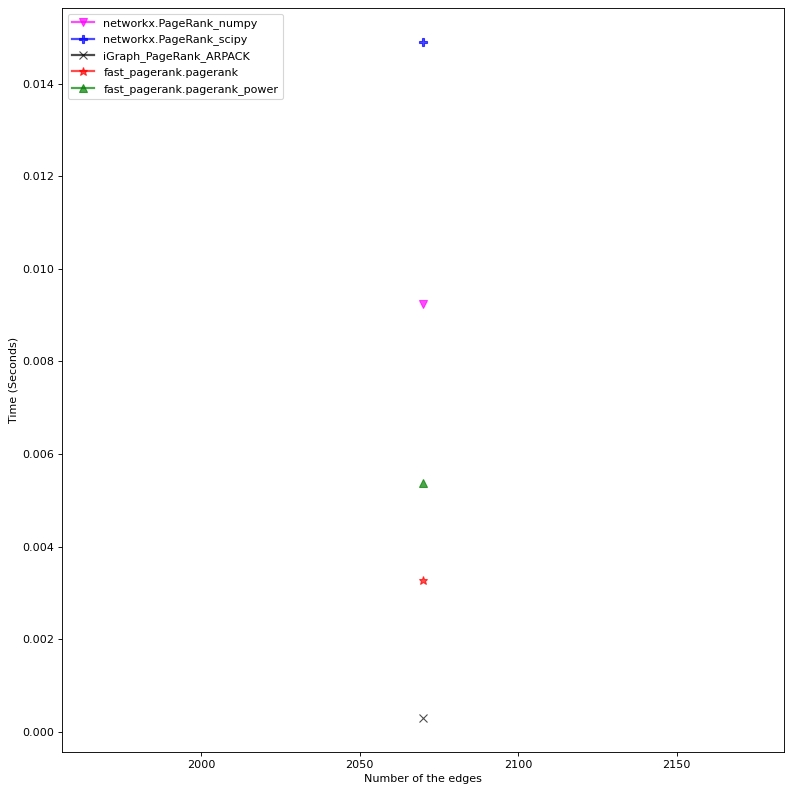

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

comparison_table = pd.read_csv('pagerank_methods_comparison.csv', index_col=0)
display(comparison_table)

plt.ioff()
fig=plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')


# plt.plot(comparison_table['Edges'], comparison_table['NetX'],
#          'o-', ms=8, lw=2, alpha=0.7, color='cyan',
#          label='networkx.PageRank')
plt.plot(comparison_table['Edges'], comparison_table['NetX (numpy)'],
         'v-', ms=8, lw=2, alpha=0.7, color='magenta',
         label='networkx.PageRank_numpy')

plt.plot(comparison_table['Edges'], comparison_table['NetX (scipy)'],
         'P-', ms=8, lw=2, alpha=0.7, color='blue',
         label='networkx.PageRank_scipy')

plt.plot(comparison_table['Edges'], comparison_table['iGraph'],
         'x-', ms=8, lw=2, alpha=0.7, color='black',
         label='iGraph_PageRank_ARPACK')

plt.plot(comparison_table['Edges'], comparison_table['(fast) pagerank'],
         '*-', ms=8, lw=2, alpha=0.7, color='red',
         label='fast_pagerank.pagerank')
                          
plt.plot(comparison_table['Edges'], comparison_table['(fast) pagerank_power'],
         '^-', ms=8, lw=2, alpha=0.7, color='green',
         label='fast_pagerank.pagerank_power')


plt.xlabel('Number of the edges')
plt.ylabel('Time (Seconds)')


plt.tight_layout()
plt.legend(loc=2)
plt.savefig('pagerank_methods_comparison.png')
plt.show()
